# STEPS
We perform the following steps 
1.	We read the images from the text file **links.txt**
2.	Then the images are **Resized (480,480)** as the images are of different qualities
3.	Next, we make a copy of the image to draw contours
4.	Afterwards, we convert the image to **Grayscale**
5.	Next, we apply the **Bilateral Filter** to preserve the edges
6.	In the next step, we apply Median Thresholding to define **upper and lower thresholds **for the canny algorithm.
7.	To deal with images having near to same colour background as the card, we apply a simple **Thresholding** function. 
8.	Next, we calculate the percentage of the concerned image in the foreground and background. **If the percentage is less, we use the Adaptive Filter.**
9.	The **Threshold is Inversed** so that the foreground is white, and the canny algorithm works better on it.
10.	Next, we apply the **Canny Algorithm** to the image
11.	Next, we perform **Closing** if the percentage is less than **45 and Dilation otherwise**
12.	After **Closing/Dilation** to get a **whole object**, we extract **External Contours and use Simple Chain Approximation **
13.	Next, we **Sort Contours** with respect to the **Area**
14.	Next, we use the **Arc Length** and then fill the **Polygon Shape.**
15.	If the polygon is not exactly correct, then we use approximation by selecting the **Biggest Shape Area**.
16.	Afterwards, we draw a **Bounding Box** with respect to height and width and then crop the image.
17.	**From our sample images, we get approximately 90% accuracy.**



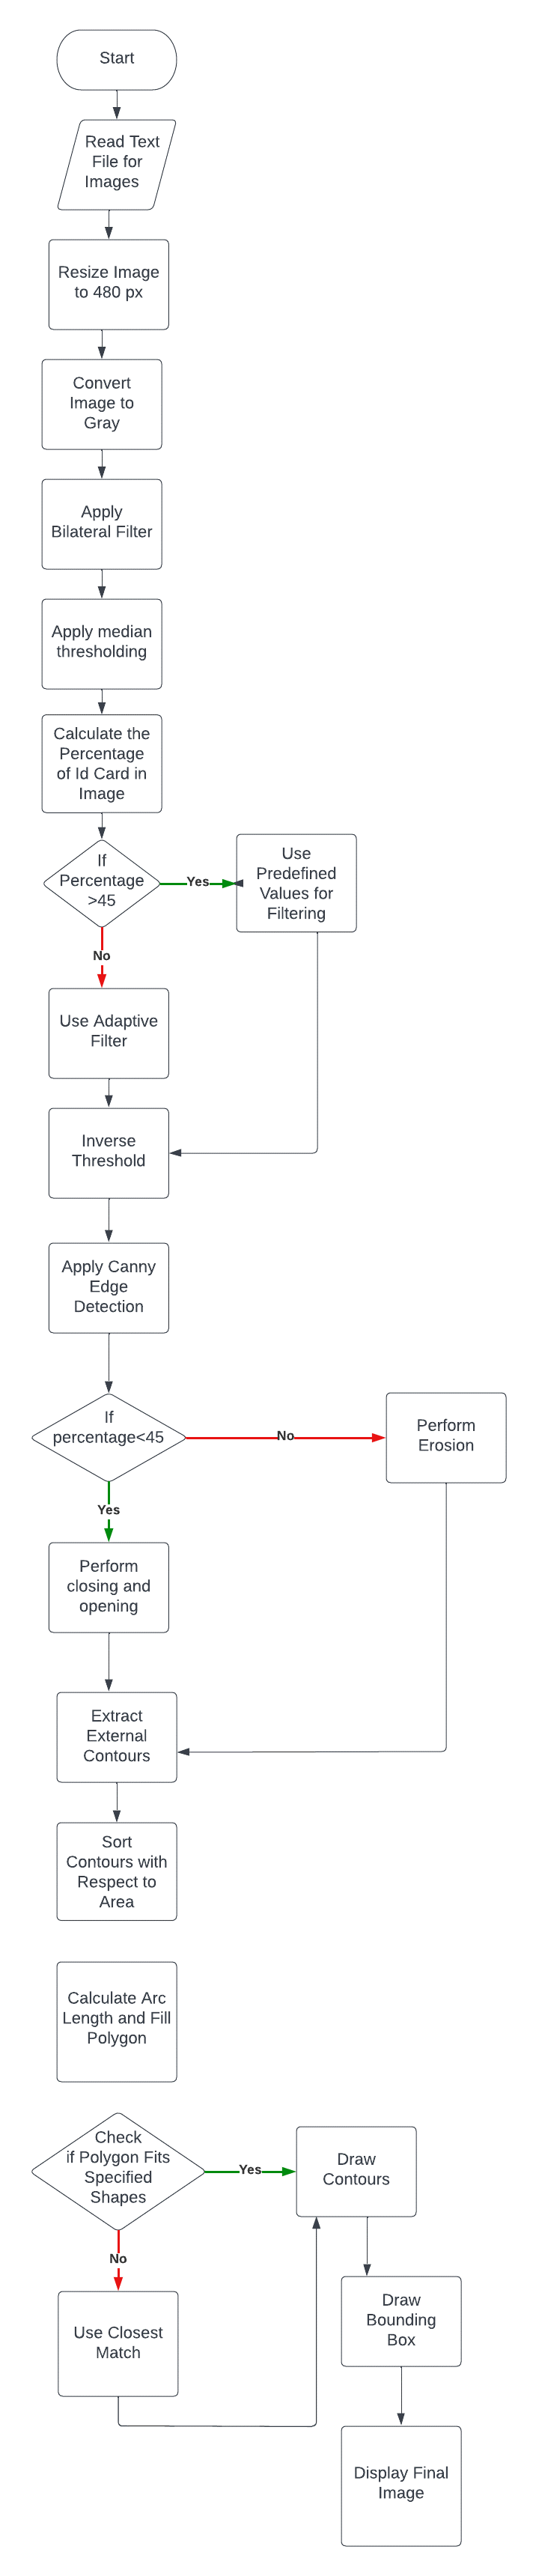

In [ ]:
# Libraries
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance
from os import path
import numpy as np
import os.path
import urllib.request
import time
import PIL
import cv2
import scipy.misc
from skimage import io

def CNIC_segmentation(img):
  
  document_img = img
  # Resizing Image
  document_img= cv2.resize(document_img, (480,480))
  src = document_img.copy()
  # Making a Copy to Draw Contours On
  crp= document_img.copy()
  # Display the image
  plt.figure(figsize=[5,5])
  plt.imshow(document_img[:,:,::-1]);plt.title("Original Image");plt.axis("off");

  # Converting To GrayScale
  gray = cv2.cvtColor(document_img,cv2.COLOR_BGR2GRAY)
  plt.figure(figsize=[5,5])
  plt.imshow(gray, cmap='gray');plt.title("Grascale Image");plt.axis("off");
  # Storing Shape of Image
  h,w= gray.shape
  # Bilateral Filter
  fil = cv2.bilateralFilter(gray, 7, 1000, 1000)
  plt.figure(figsize=[5,5])
  plt.imshow(fil, cmap='gray');plt.title("Bilateral Image");plt.axis("off");

  # Calculating Upper and Lower Threshold Values For Canny
  v = np.median(fil)
  sigma = 0.33

  #Optimal Canny Threshold
  lower_thresh = int(max(0, (1.0 - sigma) * v))
  upper_thresh = int(min(255, (1.0 + sigma) * v))

  # Manual Threshold
  ret,thresh = cv2.threshold(fil,155,255,cv2.THRESH_BINARY_INV)
  # Calculating Percentage of Black After Threshold
  r= h*w
  count=0
  number= 255
  for i in range(h):
      for j in range(w):
          if thresh[i][j] != number:
              count=count+1;

  percentage= (count/r)*100
  # If upper a specific range use Adaptive Threshold
  if percentage>= 40:
      thresh = cv2.adaptiveThreshold(fil, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

  # Inversing For Better Canny Results
  thresh= ~thresh

  plt.figure(figsize=[5,5])
  plt.imshow(thresh, cmap='gray');plt.title("Thresh Image");plt.axis("off");

  # Canny
  image= thresh.copy()

  canny = cv2.Canny(image,10, 0)
  plt.figure(figsize=[5,5])
  plt.imshow(canny, cmap='gray');plt.title("Canny Image");plt.axis("off");


  # Dilation/ Closing
  kernel = np.ones((5,5), np.uint8)
  if percentage <= 45:
      erode = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=4)
  else:
      erode= cv2.dilate(thresh, kernel, iterations=2)
      


  plt.figure(figsize=[5,5])
  plt.imshow(erode, cmap='gray');plt.title("Morphed Image");plt.axis("off");

  # Finding Contours In Image
  contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # TREE / SIMPLE # Erode
  # Sorting According to Area Size
  cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
  # Storing the Biggest Area
  biggest =  max(contours, key = cv2.contourArea)

  screenCnt = None
  # Looping Over Contours
  for c in cnts:
      # approximate the contour
      peri = cv2.arcLength(c, True)
      # Approximated Polygon Figure
      approx = cv2.approxPolyDP(c, 0.015 * peri, True)

      # if our approximated contour has four points, then
      # we can assume that we have found our screen
      if len(approx) == 4:
          screenCnt = approx
          break
  # Check Which Area To Use
  tag=0
  if(len(approx) < len(biggest)):
      cv2.drawContours(src, [biggest], -1, (0, 255, 0), 3)
      tag=1
  else:
      cv2.drawContours(src, [approx], -1, (0, 255, 0), 3)

  # Display the image
  plt.figure(figsize=[5,5])
  plt.imshow(src[:,:,::-1]);plt.title("Contour Image");plt.axis("off");

  # BOUNDING BOX
  mask = np.zeros((h,w))
  recCopy= src.copy()
  # Depending On The Area Selected
  if tag==1:
      x,y,height,width= cv2.boundingRect(biggest)
      cv2.fillConvexPoly(mask, biggest, 1)
  else:
      x,y,height,width= cv2.boundingRect(approx)
      cv2.fillConvexPoly(mask, approx, 1)
  # Adding Name On Box
  cv2.rectangle(recCopy, (x,y), (x+height, y+ width), (0,0,255),4)
  cv2.putText(recCopy, 'NIC Detected', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 3, cv2.LINE_AA)
  # Display the result
  plt.figure(figsize=[10,10])
  plt.imshow(recCopy[:,:,::-1]);plt.axis("off");plt.title('Contours Drawn');
  # Cropping Image
  cropped_image = crp[y:y+width, x:x+height]
  plt.figure(figsize=[10,10])
  plt.imshow(cropped_image[:,:,::-1]);plt.axis("off");plt.title('Cropped Drawn');

  # MASK
  # Display the result
  plt.figure(figsize=[10,10])
  plt.imshow(mask, cmap='gray');plt.axis("off");plt.title('Masked Image');

In [ ]:

#method that reads the image links from a text file and passes the links to the segmentation method
def readLinks(fileName):
  with open('links.txt','r') as file:   
      for line in file: 
        #seperating links based on space     
          for path in line.split():  
            #calling the segmentation method 
               image = io.imread(path)
               CNIC_segmentation(image)

    


ValueError: ignored

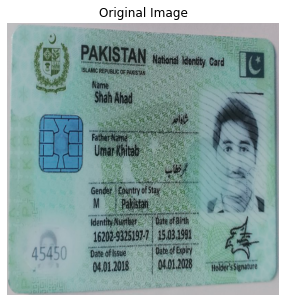

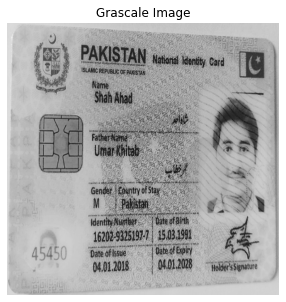

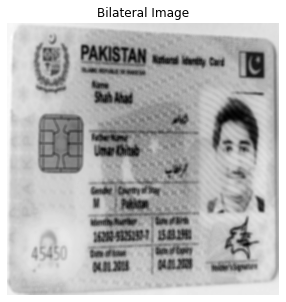

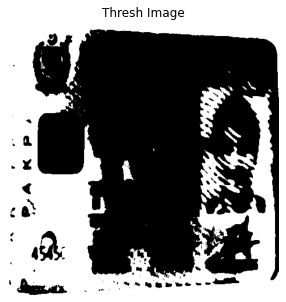

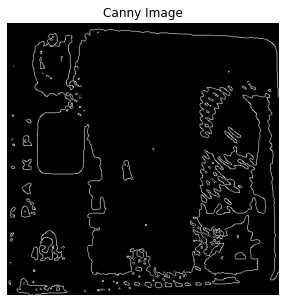

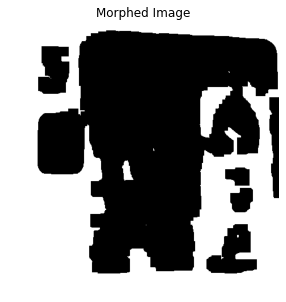

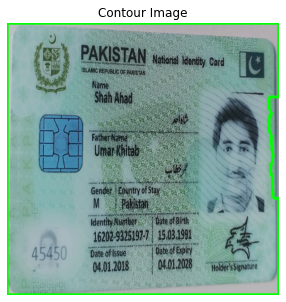

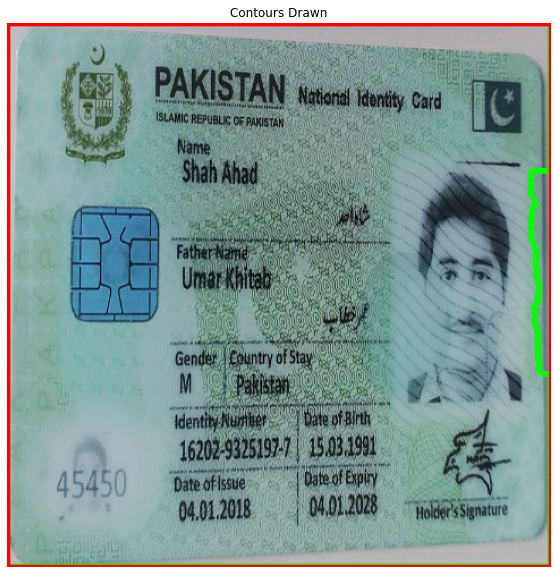

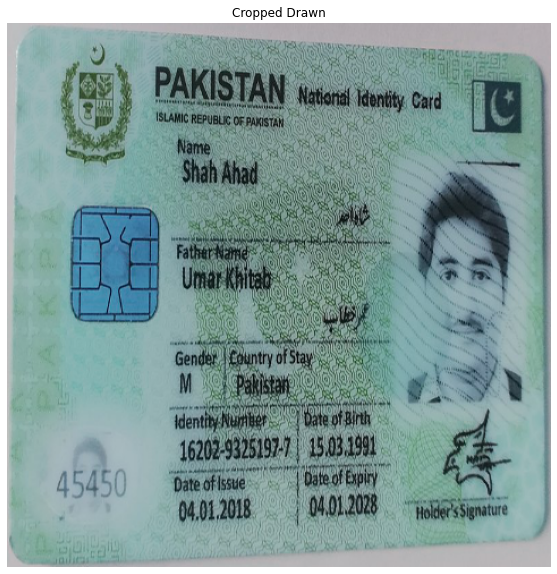

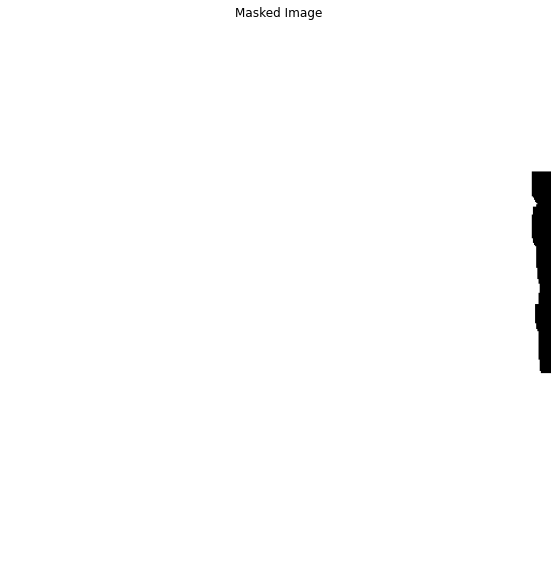

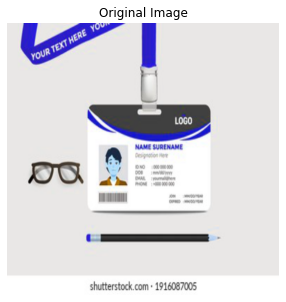

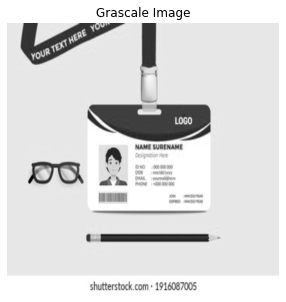

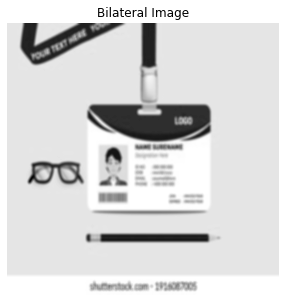

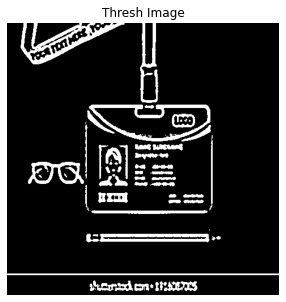

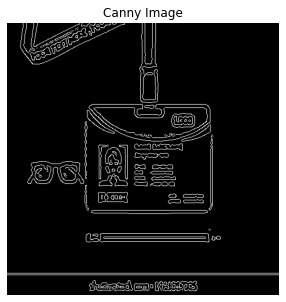

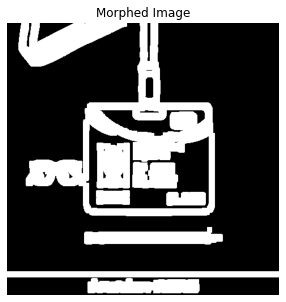

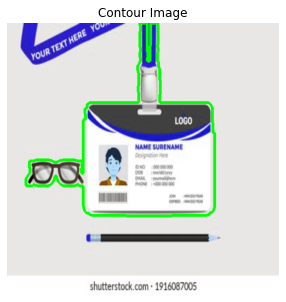

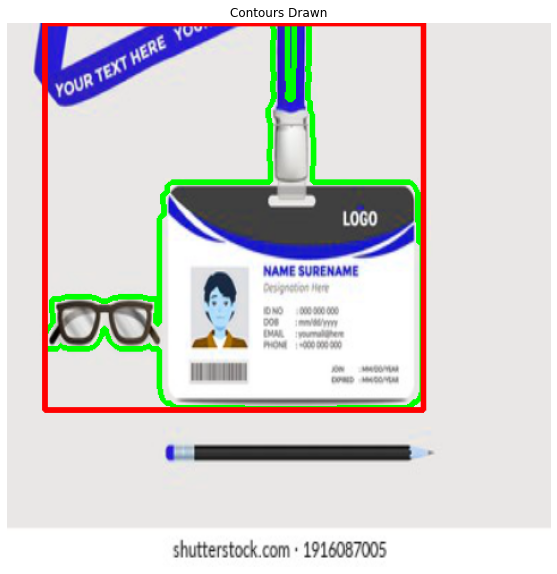

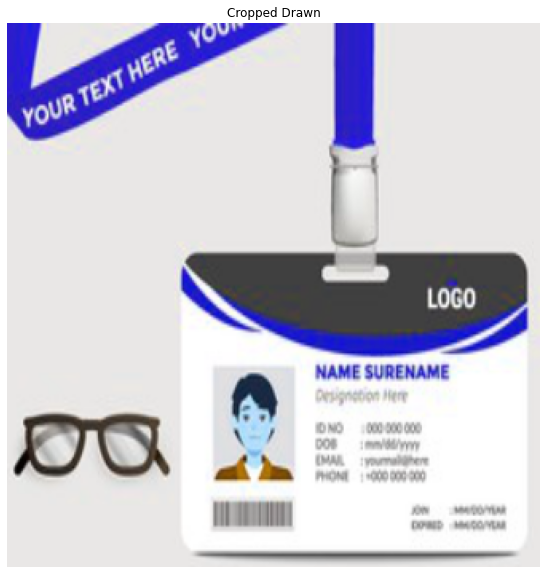

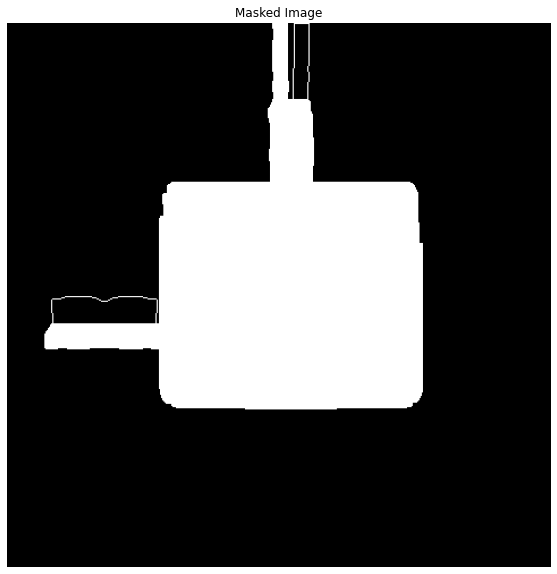

In [ ]:
# Calculating Time
st = time.time()
#calling readLinks method that calls CNIC_segmentation method for each link in the file
readLinks('links.txt')
# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')